In [155]:
import numpy as np
import pandas as pd
from collections import Counter

import cv2
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

from kmeans import *
colors = np.array(['#F94144', '#33B5E5', '#F3722C', '#90BE6D', 
                   '#43AA8B', '#228B22', '#6495ed', '#3CB371'])

In [2]:
def multi_plots(centroids, labels):
    fig, axs = plt.subplots(1,2,figsize=(8,3))
    axs[0].scatter(X[:, 0], X[:, 1], s=10)
    axs[0].scatter(np.array(centroids)[:,0], np.array(centroids)[:,1], s=10)
    axs[1].scatter(X[:,0], X[:, 1], c=colors[labels], s=10)
    plt.setp(axs, xticks=[], yticks=[])
    plt.show()

In [3]:
def centroid_plots(centroids):
    fig, ax = plt.subplots(figsize=(4,3))
    ax.scatter(X[:, 0], X[:, 1], s=10)
    ax.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], s=25)
    plt.setp(ax, xticks=[], yticks=[])
    plt.show()

# **Exploring Clustering Techniques from Scratch: K-means, K-means++, Spectral Clustering, and DBSCAN**

Clustering is a fundamental task in machine learning and data analysis that aims to group similar data points together based on their inherent characteristics. It has a wide range of applications, including customer segmentation, image segmentation, anomaly detection, and more. In this article, we will explore four popular clustering techniques from scratch: Kmeans, Kmeans++, Spectral Clustering, and DBSCAN. I will cover the basic concepts of each algorithm, their advantages and limitations, and how to implement them using Python.

Let's start from the most basic Kmeans Clustering.
K-means is a well-known unsupervised algorithm used to partition n observations into k clusters. It involves an iterative process of updating centroids and assigning observations to the nearest clusters to minimize the sum of squared distances between each data point and its assigned cluster center.     

Here are two simple examples:

#### Example 1

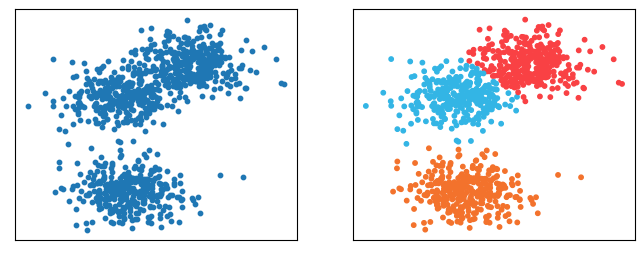

In [4]:
sample_x1, sample_y1 = make_blobs(n_samples=1000, random_state=2)
centroids, labels = kmeans(sample_x1, k=3, centroids=None, max_iter=30, tolerance=1e-2)

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(sample_x1[:, 0], sample_x1[:, 1], s=10)
axs[1].scatter(sample_x1[:,0], sample_x1[:, 1], c=colors[labels], s=10)
plt.setp(axs, xticks=[], yticks=[])
plt.show()

#### Example 2

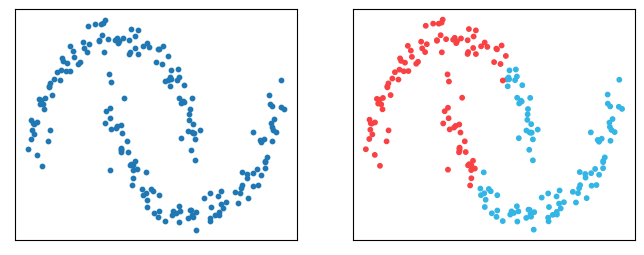

In [5]:
sample_x2, sample_y2 = make_moons(n_samples=200, noise=.07, random_state=2)
centroids, labels = kmeans(sample_x2, k=2, centroids=None, max_iter=30, tolerance=1e-2)

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(sample_x2[:, 0], sample_x2[:, 1], s=10)
axs[1].scatter(sample_x2[:,0], sample_x2[:, 1], c=colors[labels], s=10)
plt.setp(axs, xticks=[], yticks=[])
plt.show()

We can see, K-means is very powerful in identifying patterns. It works well in the first example, effectively finding the linear boundaries between clusters, however, it seems cannot capture the underlying structure of data with circular or curved shapes. 

In general, K-means has been widely used in many applications with excellent performance across various applications, including image compression, document clustering, and customer segmentation. In this article, I will present an overview of K-means, including its working mechanism, implementation, and advanced algorithms that have been developed to enhance its performance.

## [Table of contents]()
### [1. Mechanism of Kmeans](#Mechanism)
### [2. More Intelligent: Kmeans++](#kmeans++)
### [3. Applications of Kmeans](#Applications)
### [4. Upgrade: Spectral Clustering](#Spectral)
### [5. Upgrade: DBSCAN](#DBSCAN)


## 1. Mechanism of Kmeans <a name="Mechanism"></a>

The K-means algorithm works as follows:

1. Initialize k centroids randomly    
2. Assign each observation to the cluster with the nearest centroid   
3. Recalculate the mean point of each cluster and set them as new centroids    
4. Repeat steps 2 and 3 until convergence (i.e., the norm between pre-centroids and cur-centroids lower than the threshold)   

Let's work through the process with the example 1 to have a better understanding!

#### Step 1: Initialize k centroids randomly

To begin the K-means algorithm, we must first choose K centroids for our dataset. With these initial centroids, we can then proceed with the rest of the K-means algorithm to cluster the data points.

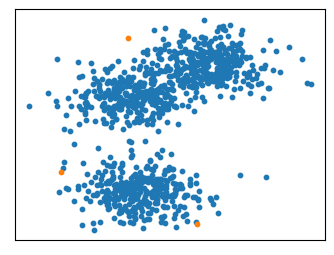

In [6]:
np.random.seed(10)
centroids = init_centroids(sample_x1, k=3)

plt.figure(figsize=(4,3))
plt.scatter(sample_x1[:,0], sample_x1[:,1], s=10)
plt.scatter(np.array(centroids)[:,0], np.array(centroids)[:,1], s=10)
plt.xticks([])
plt.yticks([])
plt.show()

#### Step 2: Assign each observation to the cluster with the nearest centroid
#### Step 3: Recalculate and update centroids

After selecting K centroids for the dataset, the next step is to assign all data points to one of the K clusters based on their distances to each centroid. The cluster which provides the closest centroid would be chosen for the point.     
Then, we recalculate the centroids by taking the mean of all the points in each cluster.     
These two steps need to be repeated iteratively until the centroids no longer change significantly between two consecutive iterations.

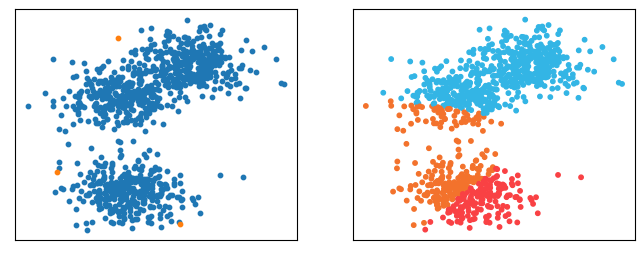

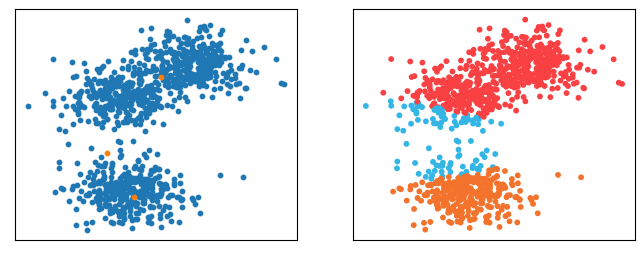

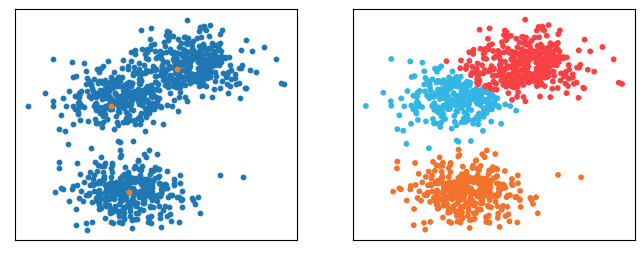

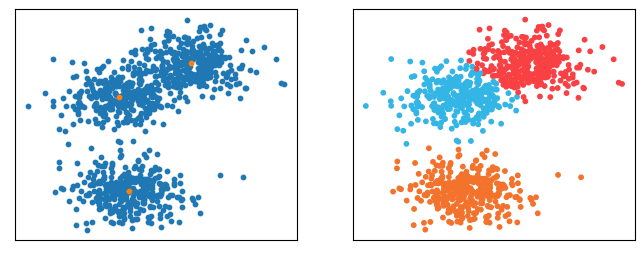

In [7]:
np.random.seed(10)
X = sample_x1
k = 3
tolerance = 1e-2
assign_result, assign_error, labels = assign_points(X, centroids)
multi_plots(centroids, labels)

for i in range(10):
    if i == 0: continue
    pre_centroids = centroids
    centroids = update_centroids(assign_result)
    if len(centroids) < k:
        refill_centroids = init_centroids(X, k - len(centroids))
        centroids = np.append(centroids, refill_centroids)
    assign_result, assign_error, labels = assign_points(X, centroids)
    if i%3 == 0: multi_plots(centroids, labels)
    if error_multi(pre_centroids, centroids) < tolerance:
        break

#### Step 4: Repeat steps 2 and 3 until convergence 

We can see a clear iteration process for the example 1 dataset. In the beginning, each iteration causes a significant change in centroids location and the points' membership in each cluster. As the algorithm progresses, the changes gradually narrow down.     
We can stop the K-means clustering when the changes in the centroid locations become small enough.

## 2. More Intelligent: Kmeans++

This is where K-means++ comes in. K-means++ is an extension of K-means that addresses the issue of initial centroid selection by using a more smarter initialization process, which can improve the performance and accuracy of the clustering process. In the following section, we'll take a closer look at how K-means++ works.

**The K-means algorithm works as follows:**

1. Select the first centroid randomly from the data points.
2. For each other point, calculate its minimum distance to any of the previously chosen centroids.
3. Choose the point which provide the max minimum distance as the next centroid.
4. Repeat step 2 and 3 until k centroids have been chosen.
5. Proceed with the standard K-means clustering algorithm using the k initial centroids obtained from the K-means++ initialization.

Let's explore how the K-means++ algorithm intelligently initializes K centroids:

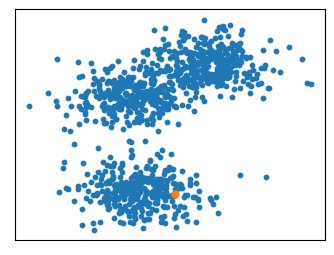

[[-0.1245713675310407, -9.736005822786678]]


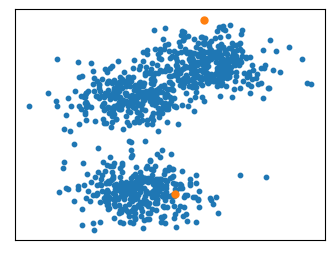

[[-0.1245713675310407, -9.736005822786678], [0.8163936687916763, 1.3860920872155438]]


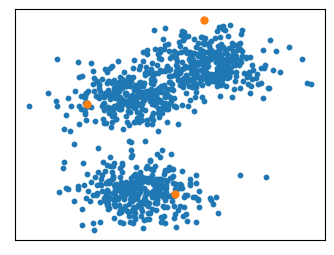

In [8]:
np.random.seed(10)
X = sample_x1
k = 3

first = np.random.choice(range(len(X)))
centroids = [X[first]]
centroid_plots(centroids)

while len(centroids) < k:
    new_centroid = update_centroids_plus(X, centroids)
    centroids.append(new_centroid)
    centroid_plots(centroids)

The Kmeans++ initialization method for centroids is purposeful, and this speeds up the clustering process. As a result, we need fewer steps to efficiently find the optimal classification method for the entire dataset:

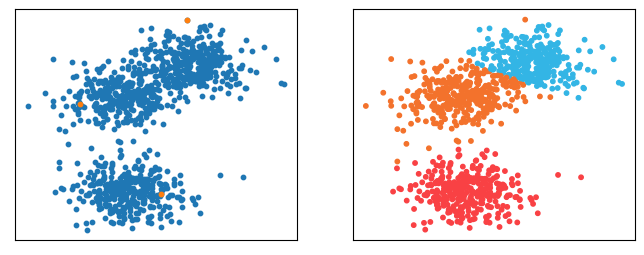

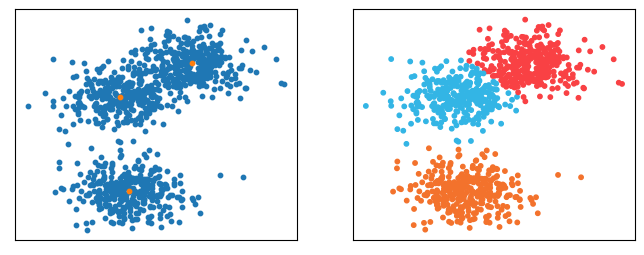

In [9]:
np.random.seed(10)
X = sample_x1
k = 3
tolerance = 1e-2
assign_result, assign_error, labels = assign_points(X, centroids)
multi_plots(centroids, labels)

for i in range(10):
    if i == 0: continue
    pre_centroids = centroids
    centroids = update_centroids(assign_result)
    if len(centroids) < k:
        refill_centroids = init_centroids(X, k - len(centroids))
        centroids = np.append(centroids, refill_centroids)
    assign_result, assign_error, labels = assign_points(X, centroids)
    if i%3 == 0: multi_plots(centroids, labels)
    if error_multi(pre_centroids, centroids) < tolerance:
        break

## 3. Applications of Kmeans <a name="Applications"></a>

### Image compression (grayscale)

Now, let's examine some specific use cases of K-means. One example is its application in grayscale image compression, which demonstrates its real-world effectiveness.

In [22]:
gray_img = cv2.imread('grey.png', cv2.IMREAD_GRAYSCALE)
X = gray_img.reshape((-1, 1))

In [23]:
centroids, labels = kmeans(X, k=4, centroids='kmeans++', 
                           tolerance=.01, verbose=True)
compressed_gray = np.choose(labels, centroids)
compressed_gray.shape = gray_img.shape
vmin, vmax = X.min(), X.max()

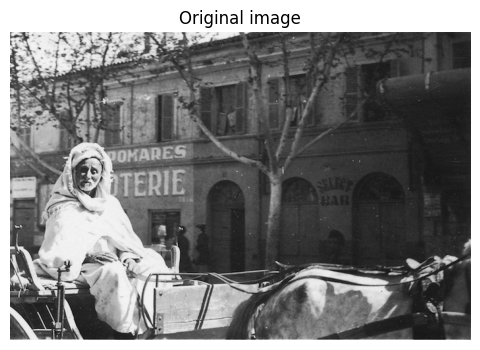

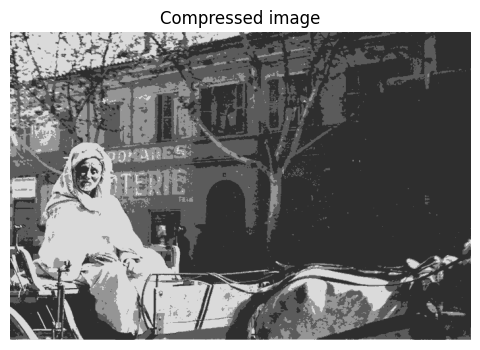

In [24]:
# origin
plt.figure(1, figsize=(6,4))
plt.axis("off")
plt.title("Original image")
plt.imshow(gray_img, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

# compressed
plt.figure(2, figsize=(6,4))
plt.axis("off")
plt.title("Compressed image")
plt.imshow(compressed_gray, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

plt.show()

Here we use Kmeans++ to determine 4 centroids for the grayscale image dataset. The algorithm assigns data points to their closest clusters and iterates until the point and cluster distributions stabilize. Finally, it compresses the image to 4 gray colors while retaining most of the original image's information.

### Image compression (with color)

Next, let's further examine the application of K-means in color image compression.

In [27]:
boy = cv2.imread('boy.jpg')
boy = np.array(boy, dtype=np.float64) / 255
w, h, d = original_shape = tuple(boy.shape)

image_array = np.reshape(boy, (w * h, d))
centroids, labels = kmeans(image_array, k=4, centroids='kmeans++')
compressed_boy = centroids[labels].reshape(w, h, -1)

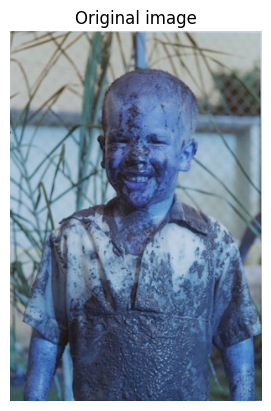

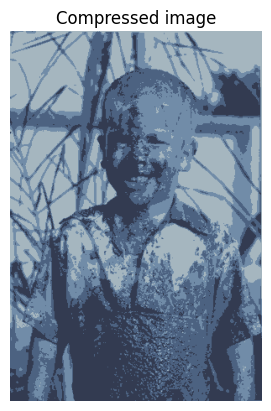

In [28]:
# origin
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image")
plt.imshow(boy)

# compressed
plt.figure(2)
plt.clf()
plt.axis("off")
plt.title("Compressed image")
plt.imshow(compressed_boy)

plt.show()

In this example, we have used only 4 colors to compress the original image as well. As a result, the richness of the colors has decreased significantly, but the fundamental information such as outlines and depth has been well preserved. This demonstrates the effectiveness of k-means as an optimization method for clustering.

## 4. Upgrade: Spectral Clustering <a name="Spectral"></a>

As we saw at the first, Kmeans is limited in its ability to handle data with nonlinear boundaries. That's because it relies on the Euclidean distance between data points and their centroid to form clusters. For example, circular data can pose a problem for Kmeans as data points that are close in a Euclidean sense may not be close in a circular sense, resulting in clusters that do not capture the underlying circular patterns. 

Spectral clustering, on the contral, is a powerful technique that is effective when data points are not well separated or when clusters have complex shapes. It is based on graph theory and employs linear algebra to partition data into clusters. By constructing a similarity graph of data points and transforming it into a matrix representation, spectral clustering computes the corresponding eigenvalues and eigenvectors. These eigenvectors are then used to project the data into a lower-dimensional space, allowing a clustering algorithm such as K-means to be applied to form clusters.

Let's explore two Spectral clustering examples:

#### Example 1: Mooned shape dataset

For a mooned shape dataset, if we try Kmeans here, it would return an unexpected clustering result.

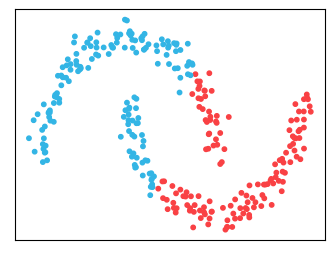

In [108]:
X, y = make_moons(300, noise=.07, random_state=10)
centroids, labels = kmeans(X, k=2, centroids=None, max_iter=30, tolerance=1e-2)

plt.figure(figsize=(4,3))
plt.scatter(X[:,0], X[:,1], c=colors[labels], s=10)
plt.xticks([])
plt.yticks([])
plt.show()

Then, let's start spectral clustering by building the proximity matrix.

This function fits a Random Forest Classifier to the data using the specified number of trees. For each tree in the model, it identifies the leaf node that each data point belongs to. Then, for each pair of data points that belong to the same leaf node, the function increments their corresponding weights in the proximity matrix.

The resulting proximity matrix is a symmetric matrix where each entry represents the number of times two data points appeared in the same leaf node across all the trees in the Random Forest model. We also need to divide the resulting matrix by the number of trees to obtain an average proximity matrix. 

In [109]:
proximity_matrix_ = proximity_matrix(X, y, number_of_trees=20)
proximity_matrix_

array([[0.  , 0.  , 0.  , ..., 0.55, 0.05, 0.  ],
       [0.  , 0.  , 0.5 , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , ..., 0.  , 0.5 , 0.  ],
       ...,
       [0.55, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.5 , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

The resulting average proximity matrix (P) can be used as an input to the Spectral clustering function. This function first calculates the degree matrix (D) and then the Laplacian matrix (L), based on the average proximity matrix.

$$D = np.diag(np.sum(P, axis=1))$$
$$L = D - P$$

In the next step, we are going to calculate the eigenvalues and eigenvectors of the Laplacian matrix, both of which are important characteristics for identifying data patterns. The eigenvalues and eigenvectors are then sorted in ascending order based on the eigenvalues, which helps to identify the most informative eigenvectors. Then we will create a feature matrix consisting of the first n clusters' eigenvectors, which would then be used as input to the K-means clustering algorithm to form the final clusters. 

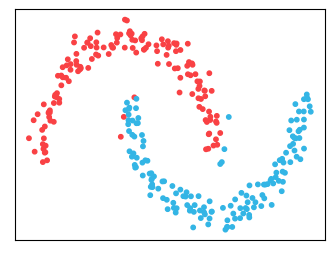

In [110]:
labels = spectral_clustering(proximity_matrix_, n_clusters=2)

plt.figure(figsize=(4,3))
plt.scatter(X[:,0], X[:,1], c=colors[labels], s=10)
plt.xticks([])
plt.yticks([])
plt.show()

As we saw, Spectral Clustering was able to accurately define the boundaries of the moon-shaped dataset. The quality of the clustering can also be evaluated using a confusion matrix and accuracy score:

In [120]:
print("Confusion Matrix: \n", confusion_matrix(y, labels))
print(f"Accuracy Score: {accuracy_score(y, labels)*100:.2f}%")

Confusion Matrix: 
 [[146   4]
 [  3 147]]
Accuracy Score: 97.67%


#### Example 2: Circle shape dataset

Same as before, for a circle shape dataset, Kmeans cannot handle it well.

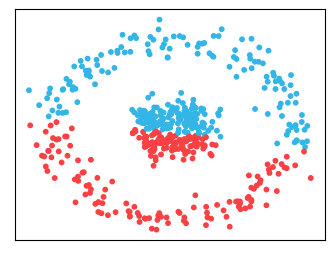

In [138]:
X, y = make_circles(n_samples=500, noise=0.1, factor=.2, random_state=10)
centroids, labels = kmeans(X, k=2, centroids=None, max_iter=30, tolerance=1e-2)

plt.figure(figsize=(4,3))
plt.scatter(X[:,0], X[:,1], c=colors[labels], s=10)
plt.xticks([])
plt.yticks([])
plt.show()

In [126]:
proximity_matrix_ = proximity_matrix(X, y, number_of_trees=20)
proximity_matrix_

array([[0.  , 0.  , 1.  , ..., 0.  , 0.5 , 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.  , 0.85],
       [1.  , 0.  , 0.  , ..., 0.  , 0.5 , 0.  ],
       ...,
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.85],
       [0.5 , 0.  , 0.5 , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.85, 0.  , ..., 0.85, 0.  , 0.  ]])

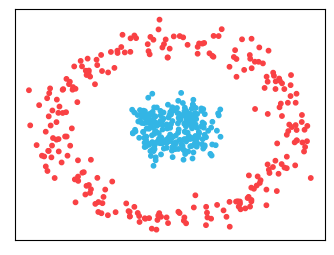

In [127]:
labels = spectral_clustering(proximity_matrix_, n_clusters=2)

plt.figure(figsize=(4,3))
plt.scatter(X[:,0], X[:,1], c=colors[labels], s=10)
plt.xticks([])
plt.yticks([])
plt.show()

In [128]:
print("Confusion Matrix: \n", confusion_matrix(y, labels))
print(f"Accuracy Score: {accuracy_score(y, labels)*100:.2f}%")

Confusion Matrix: 
 [[250   0]
 [  0 250]]
Accuracy Score: 100.00%


Spectral clustering is a powerful algorithm that is able to identify complex and nonlinear boundaries in data, as demonstrated in our analysis. Compared to k-means clustering, which is limited by its assumptions about cluster shape and size, spectral clustering is a more flexible and adaptable approach that can provide more accurate and informative results for many different application scenarios.

## Upgrade: DBSCAN <a name="DBSCAN"></a>

In this section, we are going to cover another upgrading clustering algorithm: DBSCAN. 

DBSCAN is a clustering algorithm that groups data points based on their proximity to one another, with the goal of identifying regions of high density and separating them from less dense regions. Unlike k-means, which seeks to partition the data into a fixed number of clusters, DBSCAN can identify clusters of arbitrary shapes and sizes. This makes it a powerful tool for analyzing complex data sets with non-linear boundaries and variable density.

In [157]:
X, y = make_blobs(n_samples=1000, random_state=5)

dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(X)

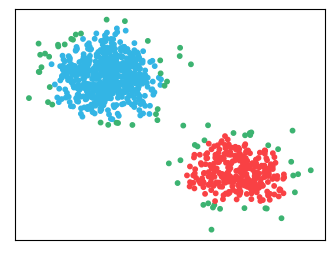

In [158]:
plt.figure(figsize=(4,3))
plt.scatter(X[:,0], X[:,1], c=colors[labels], s=10)
plt.xticks([])
plt.yticks([])
plt.show()